## Install and import packages

In [1]:
import rockmag as rmag
import pmagpy.ipmag as ipmag
import pmagpy.contribution_builder as cb
import pandas as pd
import numpy as np
from numpy.linalg import svd, lstsq
pd.set_option('display.max_columns', 500)
import ipywidgets as widgets


import matplotlib.pyplot as plt
import math
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.display import display, HTML, clear_output, Javascript 

## Import data

To pull data from MagIC, you need to define 3 parameters below:
 - `magic_id`
 - `share_key`
 - `dir_path`
 
#### If you are pulling data off of an existing, published dataset on MagIC:
 look for the MagIC contribution link associated with the dataset
 
#### If you are pulling date off of a private MagIC contribution:
 look

In [2]:
#define these three parameters to match your data
magic_id = '19548'
share_key = ''
dir_path = 'example_data/hyst'

result, magic_file = ipmag.download_magic_from_id(magic_id, directory=dir_path, share_key=share_key)
ipmag.unpack_magic(magic_file, dir_path)
contribution = cb.Contribution(dir_path)
measurements = contribution.tables['measurements'].df
measurements.dropna(axis=1, how='all')

Download successful. File saved to: example_data/hyst/magic_contribution_19548.txt
working on:  'contribution\r'
1  records written to file  C:\Users\docto\Documents\GitHub\RockmagPy-notebooks\example_data\hyst\contribution.txt
  data put in  C:\Users\docto\Documents\GitHub\RockmagPy-notebooks\example_data\hyst\contribution.txt
working on:  'locations\r'
1  records written to file  C:\Users\docto\Documents\GitHub\RockmagPy-notebooks\example_data\hyst\locations.txt
  data put in  C:\Users\docto\Documents\GitHub\RockmagPy-notebooks\example_data\hyst\locations.txt
working on:  'sites\r'
138  records written to file  C:\Users\docto\Documents\GitHub\RockmagPy-notebooks\example_data\hyst\sites.txt
  data put in  C:\Users\docto\Documents\GitHub\RockmagPy-notebooks\example_data\hyst\sites.txt
working on:  'samples\r'
1094  records written to file  C:\Users\docto\Documents\GitHub\RockmagPy-notebooks\example_data\hyst\samples.txt
  data put in  C:\Users\docto\Documents\GitHub\RockmagPy-notebooks

,analysts,citations,description,dir_csd,dir_dec,dir_inc,experiment,magn_moment,meas_field_dc,meas_n_orient,meas_temp,measurement,method_codes,quality,sequence,software_packages,specimen,standard,timestamp,treat_ac_field,treat_dc_field,treat_dc_field_phi,treat_dc_field_theta,treat_step_num,treat_temp
measurement name,,,,,,,,,,,,,,,,,,,,,,,,,
mc1002A01_LP-PI-TRM_LP-PI-ALT-PTRM_LP-PI-BT-IZZI-1,None,This study,None,0.4,261.2,-54.2,mc1002A01_LP-PI-TRM_LP-PI-ALT-PTRM_LP-PI-BT-IZZI,7.420000e-07,NaN,3.0,273,mc1002A01_LP-PI-TRM_LP-PI-ALT-PTRM_LP-PI-BT-IZ...,LT-NO:LP-PI-TRM:LP-PI-ALT-PTRM:LP-PI-BT-IZZI,g,1,pmagpy-4.2.43,mc1002a01,u,2017-02-16T08:38:00Z,0.0,0.00000,0.0,0.0,NaN,273
mc1002A01_LP-PI-TRM_LP-PI-ALT-PTRM_LP-PI-BT-IZZI-2,None,This study,None,0.4,261.7,-54.6,mc1002A01_LP-PI-TRM_LP-PI-ALT-PTRM_LP-PI-BT-IZZI,7.490000e-07,NaN,3.0,273,mc1002A01_LP-PI-TRM_LP-PI-ALT-PTRM_LP-PI-BT-IZ...,LT-T-Z:LP-PI-TRM-ZI:LP-PI-TRM:LP-PI-ALT-PTRM:L...,g,2,pmagpy-4.2.43,mc1002a01,u,2017-02-21T09:22:00Z,0.0,0.00000,0.0,0.0,1.0,373
mc1002A01_LP-PI-TRM_LP-PI-ALT-PTRM_LP-PI-BT-IZZI-3,None,This study,None,0.8,263.0,-54.5,mc1002A01_LP-PI-TRM_LP-PI-ALT-PTRM_LP-PI-BT-IZZI,7.530000e-07,NaN,3.0,273,mc1002A01_LP-PI-TRM_LP-PI-ALT-PTRM_LP-PI-BT-IZ...,LT-T-I:LP-PI-TRM-ZI:LP-PI-TRM:LP-PI-ALT-PTRM:L...,g,3,pmagpy-4.2.43,mc1002a01,u,2017-02-22T16:47:00Z,0.0,0.00003,0.0,-90.0,2.0,373
mc1002A01_LP-PI-TRM_LP-PI-ALT-PTRM_LP-PI-BT-IZZI-4,Asefaw,This study,None,0.4,260.5,-57.0,mc1002A01_LP-PI-TRM_LP-PI-ALT-PTRM_LP-PI-BT-IZZI,7.420000e-07,NaN,3.0,273,mc1002A01_LP-PI-TRM_LP-PI-ALT-PTRM_LP-PI-BT-IZ...,LT-T-I:LP-PI-TRM-IZ:LP-PI-TRM:LP-PI-ALT-PTRM:L...,g,4,pmagpy-4.2.43,mc1002a01,u,2017-03-21T11:41:00Z,0.0,0.00003,0.0,-90.0,3.0,473
mc1002A01_LP-PI-TRM_LP-PI-ALT-PTRM_LP-PI-BT-IZZI-5,Asefaw,This study,None,0.4,262.4,-56.4,mc1002A01_LP-PI-TRM_LP-PI-ALT-PTRM_LP-PI-BT-IZZI,7.250000e-07,NaN,3.0,273,mc1002A01_LP-PI-TRM_LP-PI-ALT-PTRM_LP-PI-BT-IZ...,LT-T-Z:LP-PI-TRM-IZ:LP-PI-TRM:LP-PI-ALT-PTRM:L...,g,5,pmagpy-4.2.43,mc1002a01,u,2017-03-22T10:16:00Z,0.0,0.00000,0.0,0.0,4.0,473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mc1227h1_LP-DIR-T-319,Asefaw,This study,None,0.3,66.3,69.4,mc1227h1_LP-DIR-T,1.560000e-05,NaN,3.0,273,mc1227h1_LP-DIR-T-319,LT-T-Z:LP-DIR-T,g,33077,pmagpy-4.2.43,mc1227h1,u,2020-06-25T20:41:00Z,0.0,0.00000,0.0,0.0,2.0,473
mc1227h1_LP-DIR-T-320,Asefaw,This study,None,0.3,69.5,71.1,mc1227h1_LP-DIR-T,1.200000e-05,NaN,3.0,273,mc1227h1_LP-DIR-T-320,LT-T-Z:LP-DIR-T,g,33078,pmagpy-4.2.43,mc1227h1,u,2020-06-26T11:37:00Z,0.0,0.00000,0.0,0.0,3.0,573
mc1227h1_LP-DIR-T-321,Asefaw,This study,None,0.3,76.8,72.6,mc1227h1_LP-DIR-T,1.040000e-05,NaN,3.0,273,mc1227h1_LP-DIR-T-321,LT-T-Z:LP-DIR-T,g,33079,pmagpy-4.2.43,mc1227h1,u,2020-06-26T13:40:00Z,0.0,0.00000,0.0,0.0,4.0,673


## All of the project data is now stored in the $measurements$ variable

The method codes relevent to hysteresis loops are:
 - `LP-HYS` for regular hysteresis loops
 - `LP-HYS-O` for hysteresis loops as a function of orientation
 - `LP-HYS-T` for hysteresis loops as a function of temperature

In [3]:
# plot the hysteresis loop (looking for 'LP-HYS')
rmag.make_hyst_plots(measurements, data_type = 'magn_moment')

Dropdown(description='Specimen:', options=('mc04c-1', 'mc113a1-1', 'mc117a2-1', 'mc120a2-1', 'mc129a1-1', 'mc1…

RadioButtons(description='Plot with:', options=(('matplotlib', False), ('plotly', True)), value=False)

Output()

In [4]:
# select method code, specimen, and experiment that you want to focus on
method, specimen, experiment = rmag.interactive_method_specimen_selection(measurements)

Dropdown(description='Method Code:', options=('LT-NO:LP-PI-TRM:LP-PI-ALT-PTRM:LP-PI-BT-IZZI', 'LT-T-Z:LP-PI-TR…

Dropdown(description='Specimen:', options=('mc1002a01', 'mc1003b01', 'mc1004d02', 'mc1006b01', 'mc1007a02', 'm…

Dropdown(description='Experiment:', options=('mc1002A01_LP-PI-TRM_LP-PI-ALT-PTRM_LP-PI-BT-IZZI',), value='mc10…

In [5]:
# extract the specimen specific data
hyst_data = rmag.extract_hysteresis_data(measurements, specimen.value)

### old import

####set the dir_path to the directory where the measurements.txt file is located
dir_path = './example_data/ECMB'

file = dir_path + '/measurements.txt'
measurements = pd.read_csv(file, sep='\t', skiprows=1)


### old plot

rmag.make_hyst_plots(measurements)

### old selection

specimen_name = 'NED1-5c'
hyst_data = rmag.extract_hysteresis_data(measurements, specimen_name)

## Loop processing

The first step to loop processing involve gridding the data to be equally spaced. As recommended by Jackson & Solheid (2010), linearly interpolating between the points perserves the the noise in the data for statistical interpretation. 

In [7]:
#loop_fields = []
#loop_moments = []
#print(hyst_data['meas_field_dc'])
loop_moments = hyst_data['magn_moment'] # change as necessary
loop_fields = hyst_data['meas_field_dc']
"""
for x in hyst_data['meas_field_dc']:
    s1=x
    loop_fields.append(float(s1))
for x in hyst_data['magn_mass']:
    s1=x
    loop_moments.append(float(s1))  
    """
n_loop = len(loop_fields)


polydegree = 1
nsmooth = 3
B_offset = 0
M_offset = 0
acheckvar= 0
print(n_loop)
#plt.plot(loop_fields, loop_moments)

502


In [8]:
loop_fields

measurement name
1      0.9996
2      0.9940
3      0.9863
4      0.9784
5      0.9703
        ...  
498    0.9652
499    0.9732
500    0.9811
501    0.9890
502    0.9996
Name: meas_field_dc, Length: 502, dtype: float64

In [9]:
loop_moments

measurement name
1      0.000005
2      0.000005
3      0.000005
4      0.000005
5      0.000005
         ...   
498    0.000005
499    0.000005
500    0.000005
501    0.000005
502    0.000005
Name: magn_moment, Length: 502, dtype: float64

In [10]:
# first call to loop_grid ignores offsets
grid_fields, grid_moments =rmag.loop_grid(n_loop, polydegree, nsmooth, loop_fields, loop_moments, B_offset, M_offset)

Text(0.5, 1.0, 'Gridded Data')

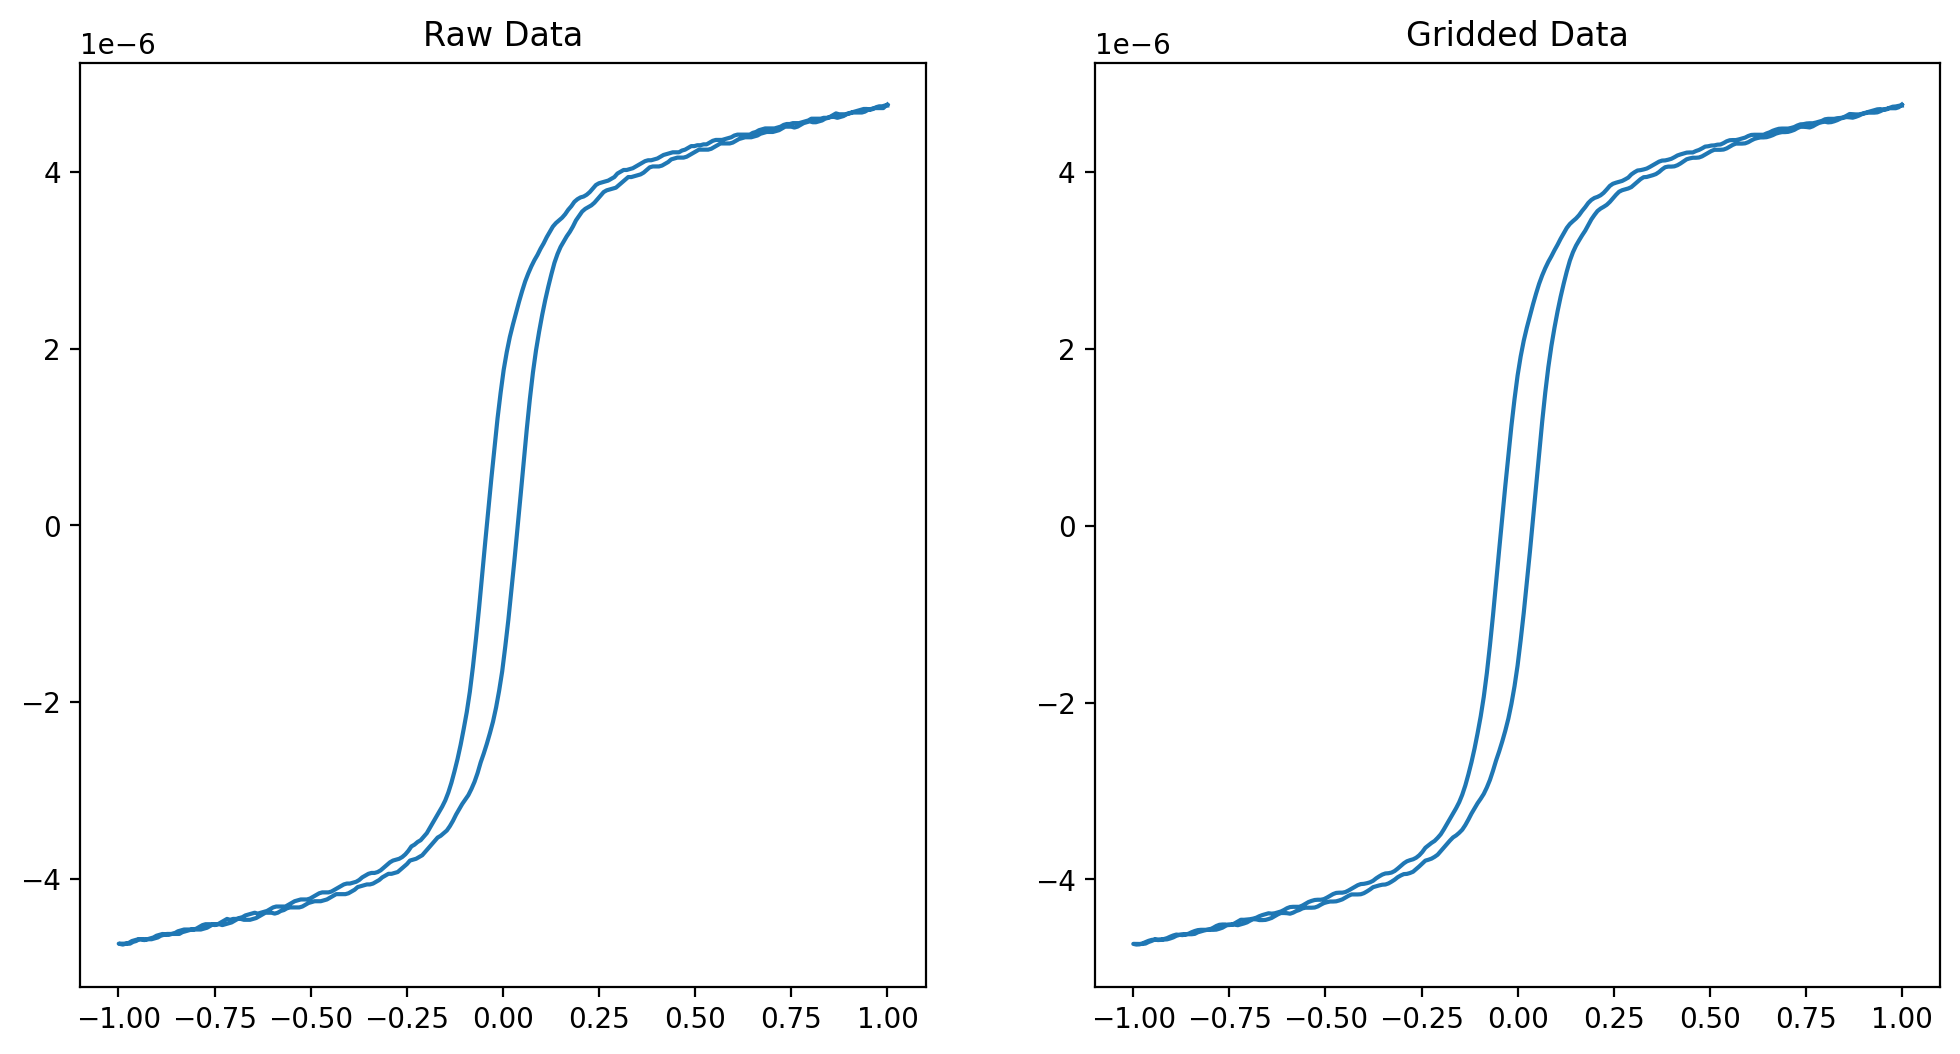

In [16]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].plot(loop_fields, loop_moments)
ax[1].plot(grid_fields, grid_moments)

ax[0].set_title('Raw Data')
ax[1].set_title('Gridded Data')


Ideally, these two should be virtually indistinguishable...

In [12]:
#This is just testing
moment_sub = rmag.branch_sub(n_loop, grid_moments)

In [13]:
len(moment_sub)

251

In [14]:
len(grid_fields)

502

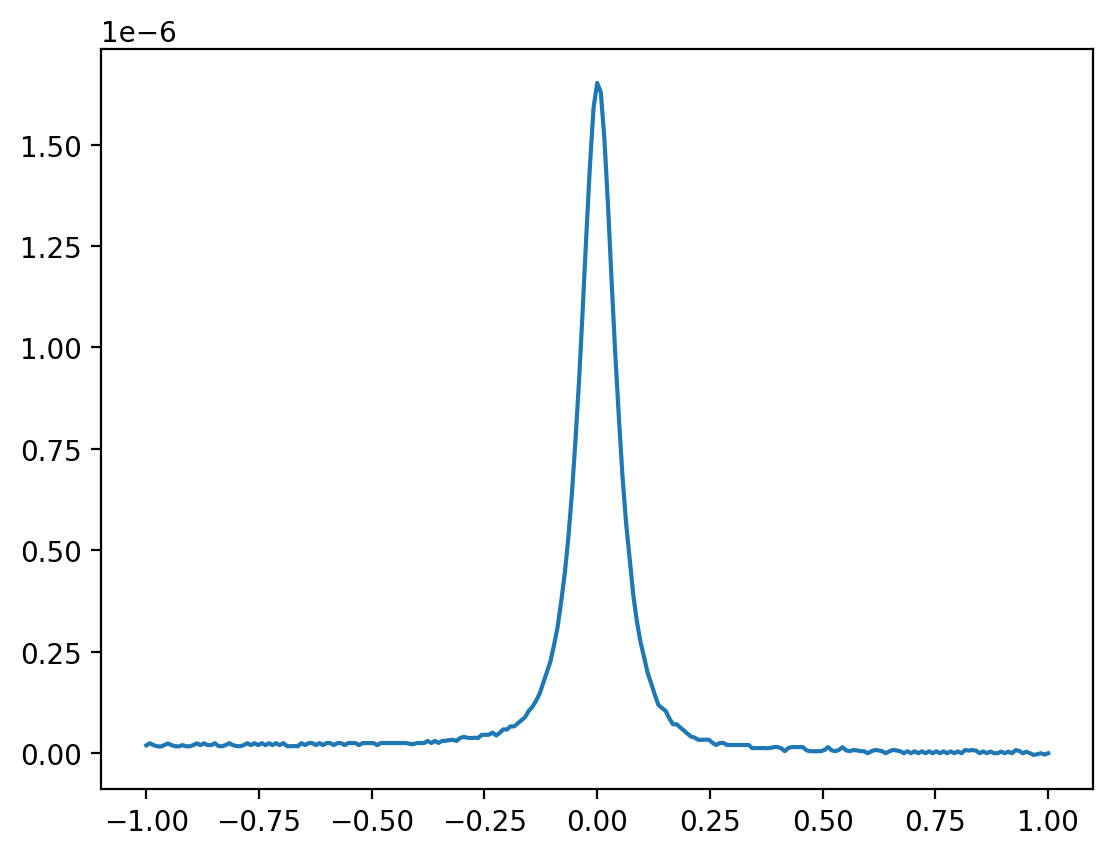

In [16]:
plt.plot(grid_fields[251:], moment_sub)

In [17]:
n_looppoints = n_loop
FNL, slope, intercept = rmag.loop_test_linearity(n_looppoints, grid_fields, grid_moments)
print("FNL = ",FNL)
print("slope = ",slope)
print("intercept = ",intercept)

FNL =  7841.442858855786
slope =  7.580305357344855e-06
intercept =  9.171232597574122e-09


In [18]:
M_offset, B_offset, M_sn = rmag.loop_errorcal(n_looppoints, grid_fields, grid_moments);
print('good luck')
print("M_offset = ",M_offset)
print("B_offset = ",B_offset)

"""
A quality factor Q is calculated for both the whole curve, Q, and the ferromagnetic part, Qf.
Q is the decimal log of the signal/noise ratio, calculated from the mean square mismatch
between symmetrically equivalent moments, and typically ranges between 0 (s/n~1) and ~3 (s/n~1000).
A higher value indicates better quality data.

"""


if M_sn > 0:
    Q = math.log(M_sn, 10) * -1
else:
    Q = 10
print("Q = ",Q)

good luck
M_offset =  4.597958872454077e-10
B_offset =  -0.0016295603530292978
Q =  3.1645108166720513


In [19]:
# second call to grid routine removes offsets
grid_fields, grid_moments = rmag.loop_grid(n_loop, polydegree, nsmooth, loop_fields, loop_moments, B_offset, M_offset)
print ("grid_moments = ",grid_moments[0])
print ("grid_fields = ",grid_fields[0])

grid_moments =  5.359540204112755e-06
grid_fields =  0.998


In [20]:
ErrX, ErrY = rmag.loop_errorcal2(n_looppoints, grid_fields, grid_moments, 0, 0)
for i in range(10):
    print("error x and y = ",ErrX[i],", ",ErrY[i])


M_err = 0
for i in range(0, n_looppoints//2 -2):
    M_err += (ErrY[i])**2
M_err = math.sqrt(M_err / (n_looppoints//2 ) )
print("n_looppoints = ", n_looppoints//2)
print("M_err = ", M_err)

error x and y =  0.0 ,  0.0
error x and y =  0.990016 ,  1.1825723550534852e-08
error x and y =  0.982032 ,  9.080408225509523e-09
error x and y =  0.974048 ,  4.59566722490798e-09
error x and y =  0.966064 ,  9.080408225509523e-09
error x and y =  0.95808 ,  9.080408225509523e-09
error x and y =  0.950096 ,  4.506507342905738e-09
error x and y =  0.9421120000000001 ,  9.080408225612013e-09
error x and y =  0.9341280000000001 ,  1.953457784345079e-09
error x and y =  0.9261440000000001 ,  1.488457784065216e-09
n_looppoints =  251
M_err =  8.118040962189836e-09


In [21]:
mrh, E_hys, Brh, Bih = rmag.loop_delta_M(n_looppoints, grid_fields, grid_moments)
print('loop_delta_m first go')
#print("mrh =", mrh)
print("E_hys =", E_hys)
print("Brh =", Brh)
print("Bih =", Bih)

plt.subplot(1,4,1)
plt.plot(loop_fields, loop_moments)

plt.subplot(1,4,2)
plt.plot(grid_fields, grid_moments)

xpoints = grid_fields[n_loop // 2:]
apoints = grid_fields[n_loop // 2:]
plt.subplot(1,4,3)
ypoints = moment_sub
plt.plot(xpoints, ypoints)

plt.subplot(1,4,4)
zpoints = mrh[:-1]
plt.plot(apoints, zpoints)
plt.show()

IndexError: index 502 is out of bounds for axis 0 with size 502